# LSTM

## Imports

In [ ]:
!pip install pandas
!pip install numpy
!pip install torchvision
!pip install scikit-learn
!pip install tensorflow
!pip install seaborn
!pip install wandb
%pip install dotenv

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import os
from dotenv import load_dotenv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import time
from models.utils.evaluationUtility import calculate_metrics, analyze_all_results

In [ ]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

## Data and Vectorization

In [ ]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_traindata['sentiment'].tolist())

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_traindata['text'].tolist())
sequences = tokenizer.texts_to_sequences(df_traindata['text'].tolist())
padded_sequences = pad_sequences(sequences, maxlen=15, padding='post', truncating='post')

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    padded_sequences.tolist(), 
    labels.tolist(), 
    test_size=0.2, 
    random_state=42
)
train_texts = np.array(train_texts)
train_labels = np.array(train_labels)
validation_texts = np.array(validation_texts)
validation_labels = np.array(validation_labels)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
label_encoder = LabelEncoder()
labels_test = label_encoder.fit_transform(df_testdata['sentiment'].tolist())

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_testdata['text'].tolist())
sequences = tokenizer.texts_to_sequences(df_testdata['text'].tolist())
padded_sequences_test = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


## Models

In [ ]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb.init(project="nlp-lantsch-schmassmann-wigger", entity="nlp-lantsch-schmassmann-wigger")

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

class WandbCallback(wandb.keras.WandbCallback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "epoch_loss": logs["loss"],
            "epoch_accuracy": logs["accuracy"],
            "val_loss": logs["val_loss"],
            "val_accuracy": logs["val_accuracy"]
        })
        super().on_epoch_end(epoch, logs)

start_time = time.time()
history = model.fit(
    train_texts,
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_texts, validation_labels),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)
end_time = time.time()
training_duration = end_time - start_time
calculate_metrics(model, validation_texts, validation_labels, validation_texts, validation_labels, "LabelEncoder", "Tokenizer", "lstm", training_duration)

wandb.finish()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When groupi

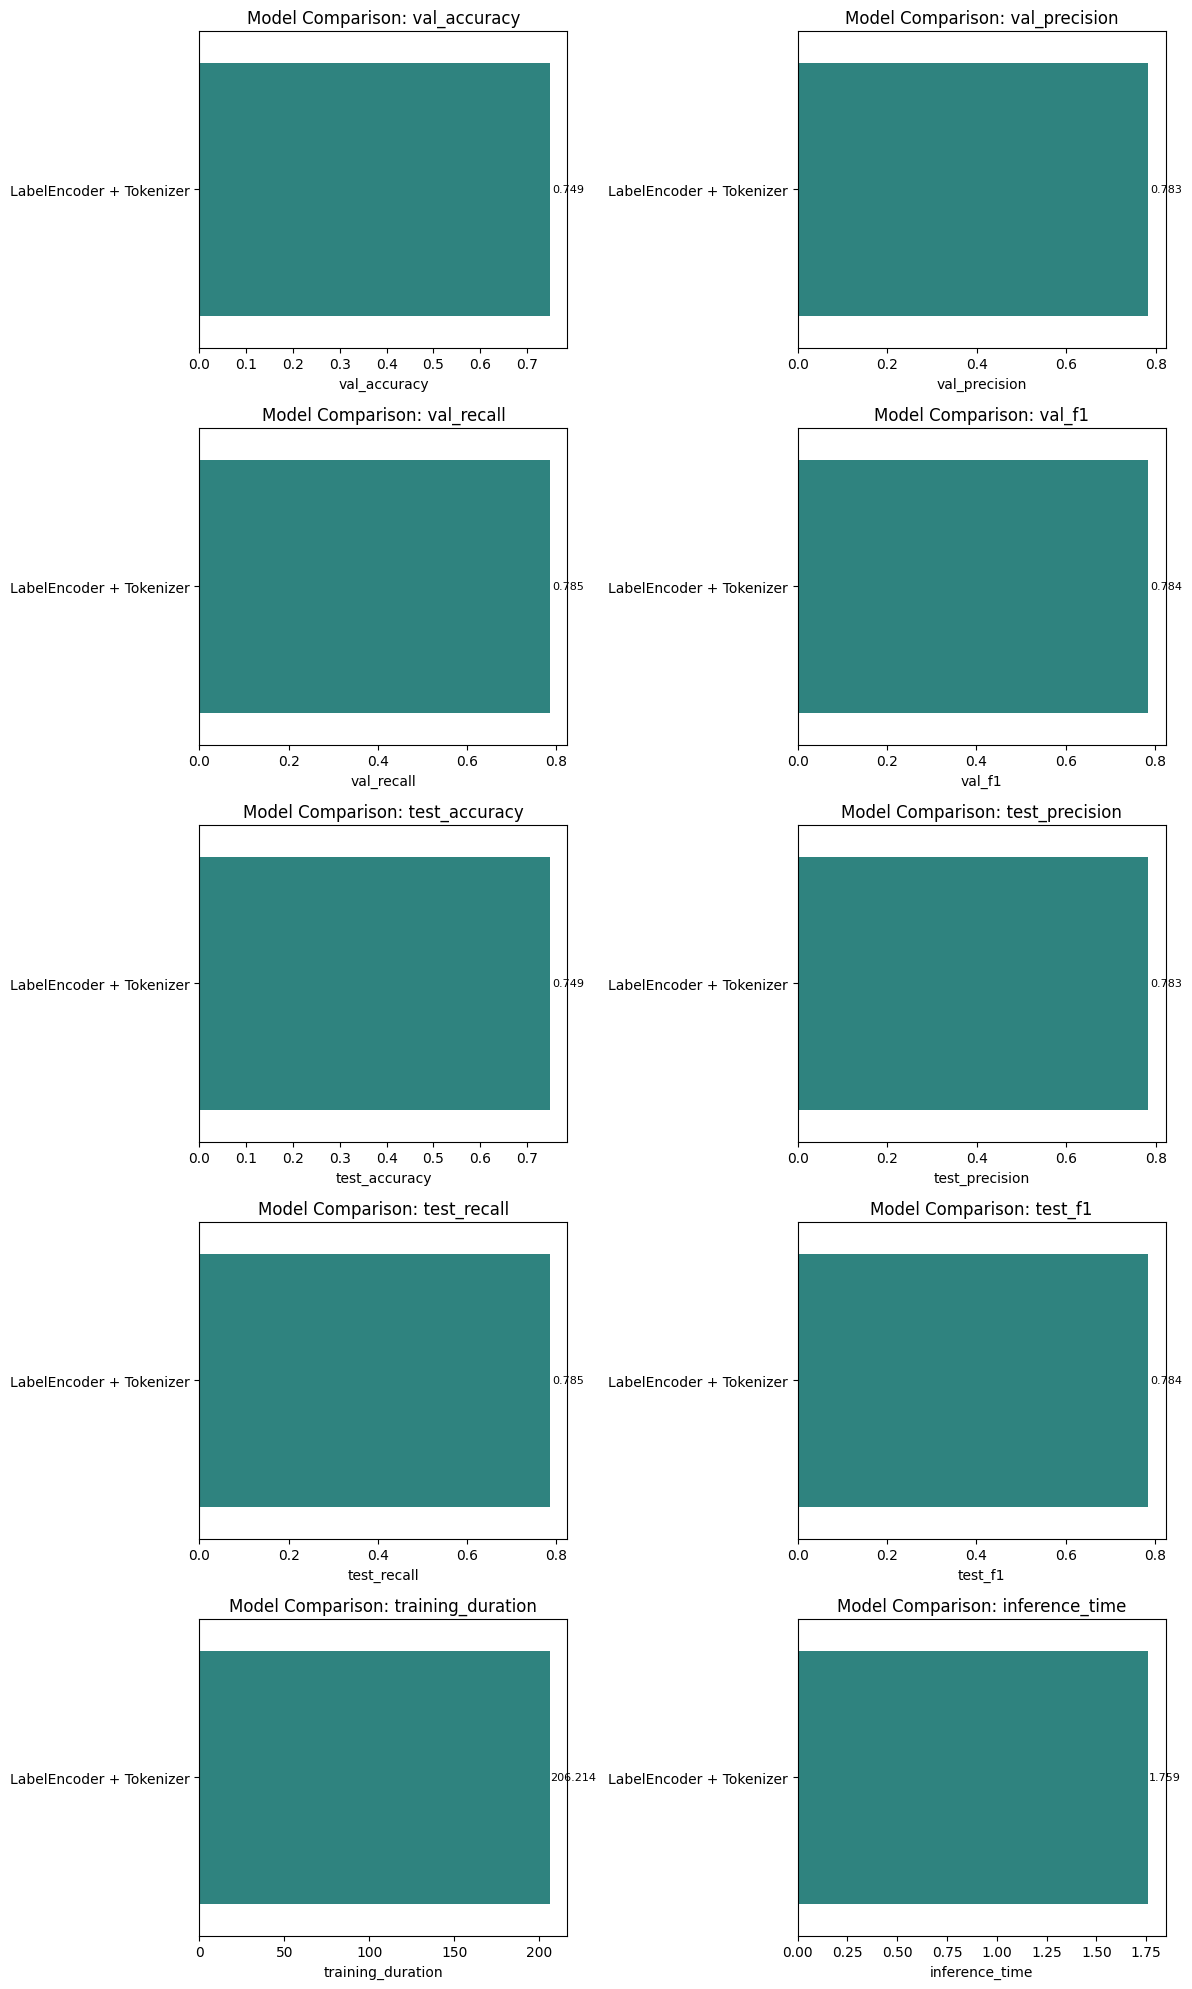

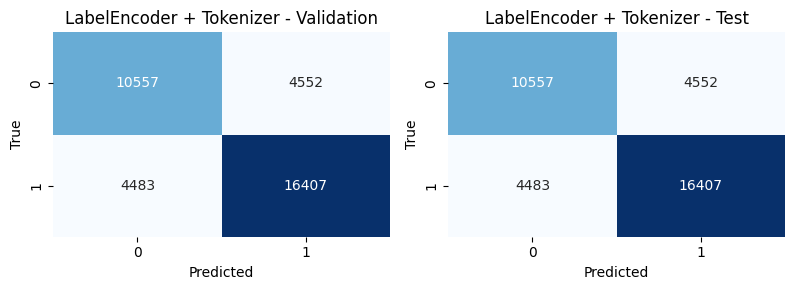

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,inference_time,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,LabelEncoder,Tokenizer,0.749021,0.782814,0.7854,0.784105,0.749021,0.782814,0.7854,0.784105,206.213629,1.759381,LabelEncoder,Tokenizer,"[[10557, 4552], [4483, 16407]]","[[10557, 4552], [4483, 16407]]",LabelEncoder + Tokenizer


In [9]:
analyze_all_results(results_dir="executions/lstm")